In [1]:
import json
from datetime import datetime
import pandas as pd
import os
import urllib.request
import matplotlib.pyplot as plt


In [2]:
# pd.DataFrame()

def extract(json_file, min_delta = 30):
    explored_routes = set()
    total_nodes = {}
    total_edges = set()
    for r in json_file["data"]:
        if r["direction"] not in explored_routes:
            explored_routes.add(r["direction"])
        
            stop_ids = {}
            
            idx = 0
            
            for i in r["stops"]:
                stop_ids[idx] = [idx, i["altId"][0], i["lon"], i["lat"], 
                      datetime.strptime(i["depDate"] + " " + i["depTime"], "%Y-%m-%d %H:%M:%S")
                      if "depTime" in i else
                      datetime.strptime(i["arrDate"] + " " + i["arrTime"], "%Y-%m-%d %H:%M:%S")]
                idx += 1
            
            #print(stop_ids)
            
            nodes = {}
            for node in stop_ids:
                nodes[stop_ids[node][1]] = (stop_ids[node][2], stop_ids[node][3])
            
            # nodes
            n_list = list(stop_ids[i][1] for i in stop_ids)
            
            times = [i[-1] for i in stop_ids.values()]
            
            time_zip = zip(times[:-1], times[1:])
            time_deltas = [max(min_delta, (t2 - t1).total_seconds()) for (t1, t2) in time_zip]
            time_deltas
            
            edges = set(list(zip(n_list[:-1], n_list[1:], time_deltas)))
            
            # edges
            total_edges.update(edges)
            total_nodes.update(nodes)
    return total_nodes, total_edges

In [3]:
# n, e = extract(json_file)

In [4]:
def fetch_route(route_num):
    if f"{route_num}.json" not in os.listdir("bus_routes"):
        print(f"fetching route {route_num} from online")
        with urllib.request.urlopen(f"http://sdgmts-proxy-transit-api-zp6id.ondigitalocean.app/api/schedules/{route_num}") as url:
            data = json.load(url)
        with open(f"bus_routes/{route_num}.json", "w") as f:
            f.write(json.dumps(data))
    else:
        with open(f"bus_routes/{route_num}.json", "r") as f:
            data = json.loads(f.read())
    return data
    # print(data)

In [5]:

routes = [201, 202, 41, 30, 921, 237, *range(1,15), 18, 20, 25, 27, 28, 
          31, 35, 43, 44, 60, 83, 84, 88, 105, 110, 115, 120, 201, 202, 215, 225, 227, 235,
          237, 280, 290, 701, 704, 705, 707, 
          709, 712, 815, 816, 832, 833, 
          834, 838, 848, 851, 852, 854, 855, 856, 864,
          872, 874, 875, 888, 891, 892, 894, 901, 
          904, 905, 906, 907, 909, 910, 916, 917,
          921, 923, 928, 929, 932, 933, 934, 936, 944, 
          945, 955, 961, 962, 963, 964, 965, 967, 968, 985, 992, 
          510, 520, 530, 535]

route_info = {}


for r in routes:
    json_file = fetch_route(r)
    try:
        (n, e) = extract(json_file)
        route_info[r] = {"nodes":n,
                        "edges":e}
    except:
        print(f"error for route {r}")

# route_info

In [ ]:
# route_info

In [7]:
keyset = []
nodedict = {}
for r in route_info:
    keyset += route_info[r]["nodes"].keys()
    nodedict = nodedict | {k:v for (k,v) in route_info[r]["nodes"].items()}  # nodeset += route_info[r]["nodes"].values()

len(keyset), len(set(keyset)), len(nodedict)

(5053, 4056, 4056)

In [8]:
import networkx as nx
G = nx.DiGraph()
import matplotlib.colors as mcolors

In [9]:
colors = []
for route in route_info:
    route_nodes = route_info[route]["nodes"]
    for id in route_nodes:
        G.add_node(id, pos=route_nodes[id])
    route_edges = route_info[route]["edges"]
    for i in route_edges:
        G.add_edge(i[0], i[1], travel_time=i[2], route=route)
        colors.append(route)

import random

bc = list(mcolors.CSS4_COLORS.keys())[15:]

random.shuffle(bc)

colors = [list(bc)[routes.index(i)] for i in colors]

Text(0.5, 1.0, 'bus networks, mts san diego')

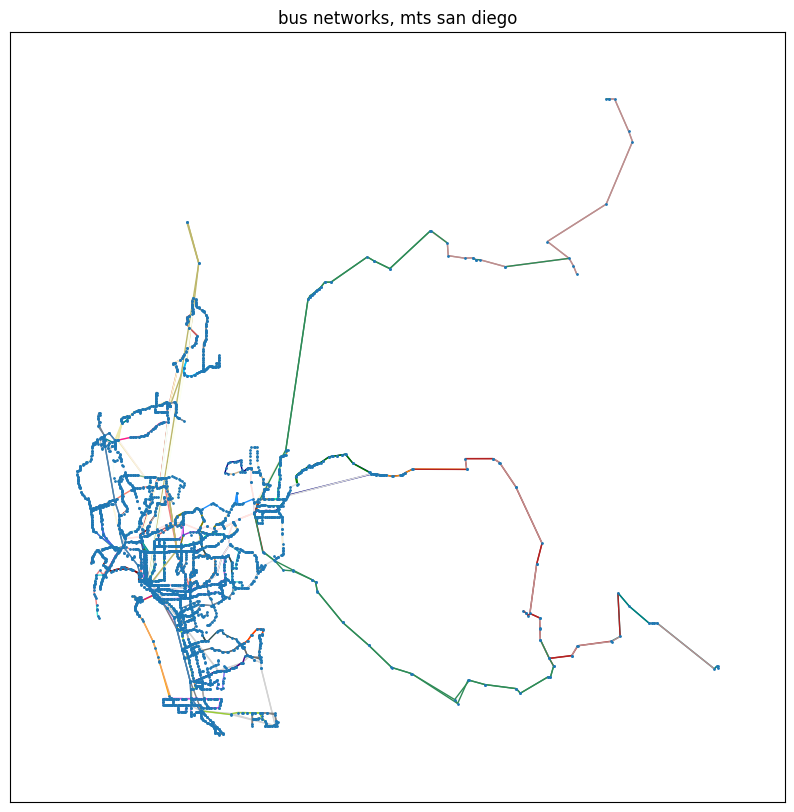

In [10]:
# nx.draw(G, nx.get_node_attributes(G, 'pos'), node_size=1)

plt.figure(figsize=(10,10))
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx_nodes(G, pos=pos, node_size = 1)
# for route in route_info:
    # print(route_info[route]["edges"])
    # G.add_weighted_edges_from(route_info[route]["edges"])
nx.draw_networkx_edges(G, pos=pos, edge_color=colors, arrows=False)
plt.title("bus networks, mts san diego")

In [11]:
import itertools
import osmnx as ox

node_pairs = itertools.combinations(nodedict.keys(), 2)
edge_list = []
radius = 200
humanspeed = 1.4

for node1, node2 in node_pairs:
        x1, y1 = nodedict[node1]
        x2, y2 = nodedict[node2]
        # Calculate Euclidean distance
        # distance = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
        distance = ox.distance.great_circle(y1, x1, y2, x2)     
    # Add edge if within the specified radius
        if distance <= radius:
            edge_list.append((node1, node2, distance/humanspeed))

#for r in route_info:

In [12]:
print(len(edge_list))
edge_list_flipped = [(i, j, k) for (j,i,k) in edge_list]

G.add_weighted_edges_from(edge_list, weight="travel_time", type="walk")
G.add_weighted_edges_from(edge_list_flipped, weight="travel_time", type="walk")


4462


In [13]:
len(nx.get_edge_attributes(G, "travel_time"))

12752

In [14]:
import matplotlib.cm as cm
import numpy as np

# partitions = nx.algorithms.community.louvain_communities(G, weight="travel_time", resolution=1, max_level=5)
partitions = nx.algorithms.community.greedy_modularity_communities(G, weight="travel_time", resolution=0.1)
print('partitioned')

node_community = {}
for community_id, community in enumerate(partitions):
    for node in community:
        node_community[node] = community_id

cmaps = cm.rainbow(np.linspace(0, 1, len(partitions)))
# random.shuffle(cmaps)
node_colors = [cmaps[node_community[node]] for node in G.nodes()]

partitioned


Text(0.5, 1.0, 'bus route communities, walk willingness = 200m')

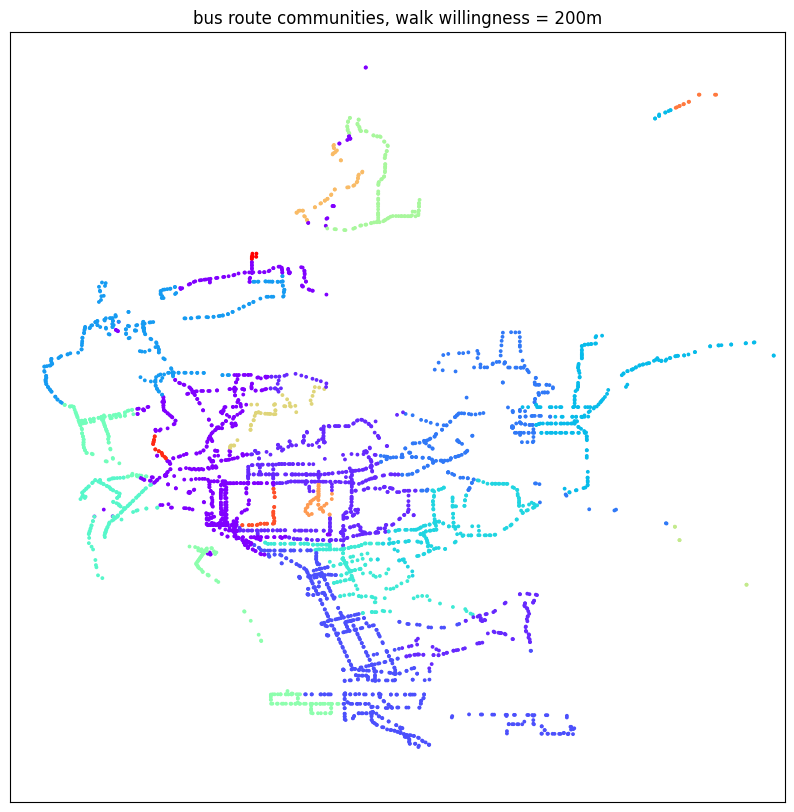

In [19]:
plt.figure(figsize=(10,10))
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx_nodes(G, pos=pos, node_size = 3, node_color=node_colors)
#nx.draw_networkx_edges(G, pos=pos, edge_color=colors, arrows=False)

# plt.gca().set_ylim(new_ylim)
# plt.gca().set_xlim(new_xlim)

#  -117.611081 	32.528832 	-116.08094 	33.505025
# new_xlim = (-117.283798122, -117.174113378) 
# new_ylim = (32.832500411999995, 32.926006188)

new_xlim = (-117.3, -116.8) 
new_ylim = (32.5, 33.1)

plt.gca().set_ylim(new_ylim)
plt.gca().set_xlim(new_xlim)
plt.title("bus route communities, walk willingness = 200m")

In [16]:
len(partitions)

20